# Task 1: Download and Visualize Sentinel 2 Data

In this task we focus on the municipality of **São Félix do Xingu** in the eastern sector of the Pará state in Brazil. The goal is to retrieve two Sentinel 2 tiles from the Copernicus AWS archive for two dates separated by a period of reported forest loss. Afterwards, you will visualize and qualitatively analyze these tiles.

## 1.0 Optional Step: Global Forest Watch Data Review

Before working with spectral data we can consult Global Forest Watch for annual forest cover change statistics in São Félix do Xingu.
Please look at the [Global Forest Watch map for São Félix do Xingu, Brazil](https://gfw.global/3H8Uut5) and evaluate the forst loss in the region.





According to [Global Forest Watch](https://gfw.global/3FKpuzl), São Félix do Xingu experienced a loss of 2.15 million hectares of tree cover between 2001 and 2024, which is about a 27 percent decrease. In the more recent period from 2018 to 2024 the municipality lost 794 thousand hectares of tree cover equivalent to a 10 percent decrease in tree cover and 345 million tonnes of carbon dioxide equivalent emissions. 
To align our satellite imagery analysis with both the magnitude of recent forest loss and the availability of high quality Sentinel 2 acquisitions we focus on the years 2018 and 2024. 

###  Contextual and Seasonal Considerations

To interpret these forest-cover statistics we must consider the principal land-use drivers in São Félix do Xingu; cattle ranching expansion and commercial agriculture have accelerated canopy removal in recent years, and infrastructure development such as logging roads fragment contiguous forest blocks.

Furthermore we must account for seasonal and atmospheric factors when selecting our two dates; the dry season in this region, roughly July through September, offers the clearest skies for optical imagery whereas the wet season introduces increased cloud cover and potential [sun-glint](https://www.euspaceimaging.com/blog/2023/12/18/how-eusi-avoids-sun-glint-in-satellite-images/) off wet leaves. 

## 1.1 Accessing Earth Observation Data via Copernicus Data Space S3

To download Sentinel-2 products from Copernicus Data Space via S3 you must first register for the Data Space service by creating a Copernicus user account. Once authenticated you can generate S3 credentials comprising an access key ID and a secret access key (see [Copernicus Data Space S3 API documentation](https://documentation.dataspace.copernicus.eu/APIs/S3.html)). Store these credentials securely in a `.env` file at the project root so that they can be loaded at runtime without exposing sensitive information.

### Detailed Task description
1. Register and obtain S3 credentials from Copernicus Data Space, store your access key ID and secret access key in a `.env` file.
   (Note: Please do not upload this file for the submission. We will use our own .env file)


### Imports
These are all imports we used when solving the task. Please leave them as is even though you might not need all of them.

In [1]:
import os
import rootutils
root = rootutils.setup_root(os.path.abspath(''), dotenv=True, pythonpath=True, cwd=False)

data_path = root / "data"
data_path.mkdir(exist_ok=True)
output_dir = root / "output"
output_dir.mkdir(exist_ok=True)


In [2]:
from datetime import date
from pathlib import Path
from typing import Optional, Iterable, Tuple

import boto3
import numpy as np
import osmnx as ox
import pandas as pd
import requests
from dotenv import load_dotenv
from collections import defaultdict
import geopandas as gpd
from shapely.geometry import Polygon


pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None) 

DESIRED_BANDS =['B02_10m', 'B03_10m', 'B04_10m', 'B08_10m',
               'B05_20m', 'B06_20m', 'B07_20m', 'B8A_20m',
               'B11_20m', 'B12_20m']

load_dotenv()  # defaults to loading .env from current dir

access_key = os.getenv("AWS_ACCESS_KEY_ID")
secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")

def dataspace_dataframe_from_attributes(
    collection: str = "SENTINEL-2",
    aoi: Optional[str] = None,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    attributes: Optional[Iterable[Tuple[str, str, float]]] = None,
    max_returned_items: int = 20
):
    """
    Get a dataframe of items from the Copernicus DataSpace API based on the given attributes.
    The request is build based on the OData standard as documented at
    https://documentation.dataspace.copernicus.eu/APIs/OData.html

    Parameters
    ----------
    collection : str
        The collection to search for. Default is "SENTINEL-2".
    aoi : str, optional
        The area of interest in WKT format. Default is None.
    start_date : str, optional
        The start date in the format "YYYY-MM-DD". Default is None.
    end_date : str, optional
        The end date in the format "YYYY-MM-DD". Default is None.
    attributes : Iterable[Tuple[str, str, float]], optional
        The attributes to filter by. Default is None which means no filtering and is equivalent to an empty list.
        Each tuple should be in the format (key, comparison, value).
        The comparison should be one of "lt", "le", "eq", "ge", "gt".
        Currently only attributes of type double and that are comparable are supported.
    max_returned_items : int, optional
        The maximum number of items to return. Default is 20. Must be in [0, 1000].
    """
    if attributes is None:
        attributes = []
    request_str = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter="
    request_str += f"Collection/Name eq '{collection}'"
    if aoi is not None:
        request_str += f" and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}')"
    if start_date is not None:
        request_str += f" and ContentDate/Start gt {start_date}T00:00:00.000Z"
    if end_date is not None:
        request_str += f" and ContentDate/Start lt {end_date}T00:00:00.000Z"
    for k, comp, v in attributes:
        assert comp in ["lt", "le", "eq", "ge", "gt"]
        request_str += f" and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq '{k}' and att/OData.CSC.DoubleAttribute/Value {comp} {v:.2f})"
    # get all attributes
    request_str += "&$expand=Attributes"
    # get top n items
    assert 0 <= max_returned_items <= 1000, f"Copernicus API only allows returned items in [0, 1000], but {max_returned_items} is outside this range."
    request_str += f"&$top={max_returned_items}"
    json_result = requests.get(request_str).json()
    json_vals = json_result['value']
    return pd.DataFrame.from_dict(json_result['value'])

def copernicus_df_to_gdf(copernicus_df: pd.DataFrame, strftime: Optional[str] = None) -> gpd.GeoDataFrame:
    """Convert Copernicus DataFrame to GeoDataFrame with spatial information."""
    if strftime is not None and strftime.lower() in ['iso', 'iso 8601', 'default']:
        strftime = '%Y-%m-%dT%H:%M:%S'
    df = copernicus_df.copy()
    # split footprint into geometry (wkt text) and crs
    # assign crs
    crss = df['Footprint'].apply(lambda x: "EPSG:"+x.split(';')[0].split("'")[1].split('=')[1])
    assert len(crss.unique()) == 1, "Multiple CRS values in data frame, geopandas can't handle that."
    # assign geometry
    df['geometry'] = gpd.GeoSeries.from_wkt(df['Footprint'].apply(lambda x: x.split(';')[1].split("'")[0]),
 crs=crss.iloc[0])
    gdf = gpd.GeoDataFrame(df)
    attribute_names = set(sl['Name'] for l in gdf['Attributes'] for sl in l)
    for attr in attribute_names:
        gdf[attr] = gdf['Attributes'].apply(lambda x: [i for i in x if i['Name'] == attr][0]['Value'] if
 len([i for i in x if i['Name'] == attr]) > 0 else np.nan)
    # Extract tileName from product name
    gdf['tileName'] = gdf['Name'].str.extract(r'_T(\w+)_')[0]
    for attr in gdf.columns:
        if 'Date' in attr:
            try:
                gdf[attr] = pd.to_datetime(gdf[attr], yearfirst=True, format='mixed')
                if strftime is None:
                    gdf[attr] = gdf[attr].values.astype(np.int64) // 10 ** 9
                else:
                    gdf[attr] = gdf[attr].dt.strftime(strftime)
            except Exception as e:
                print(f"Warning: Could not convert {attr} to datetime: {e}")
                pass
    return gdf

## 1.2 Querying the Copernicus OData API for Sentinel-2 Data

In this step, you will identify and retrieve Sentinel-2 Level 2A (L2A) imagery for São Félix do Xingu for two specific dry season periods. The goal is to obtain comparable data from both 2018 and 2024 for subsequent analysis.

**Note:** Sentinel-2 L2A products are atmospherically corrected surface reflectance data, processed from Level 1C using the Sen2Cor processor. For detailed information on these products, refer to the [Sentinel-2 L2A documentation](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a).

### Detailed Task description

1. Query the Copernicus OData API to retrieve Sentinel-2 Level 2A products satisfying the following constraints for both 2018 and 2024:

- **Area of interest:** Full envelope of São Félix do Xingu
- **Acquisition dates:** Between 20 July and 30 July  
- **Cloud cover:** Maximum of 0.5%  
- **Product type:** Level 2A (atmospherically corrected products)  
- **Spatial consistency:** Retain only those Sentinel-2 tiles that are present in both years (based on tile name)
- **Most recent tile:** ...

   You can use the function `dataspace_dataframe_from_attributes` to obtain the dataframe (see Lab01).

2. Convert both resulting DataFrames into GeoDataFrames using the available spatial metadata. Visualize them with the `explore()` method to verify whether the selected tiles overlap spatially.


In [3]:
# Get São Félix do Xingu boundaries
sao_felix = ox.geocode_to_gdf("São Félix do Xingu, Pará, Brazil")
bbox = sao_felix.envelope
aoi_wkt = bbox.to_wkt().iloc[0]

# Query 2018 data (July 20-30)
products_2018 = dataspace_dataframe_from_attributes(
    collection="SENTINEL-2",
    aoi=aoi_wkt,
    start_date="2018-07-20",
    end_date="2018-07-30",
    attributes=[
        ('cloudCover', 'le', 0.5)
    ],
    max_returned_items=100
)

# Query 2024 data (same dates)
products_2024 = dataspace_dataframe_from_attributes(
    collection="SENTINEL-2",
    aoi=aoi_wkt,
    start_date="2024-07-20",
    end_date="2024-07-30",
    attributes=[
        ('cloudCover', 'le', 0.5)
    ],
    max_returned_items=100
)

# Keep only L2A products
l2a_2018 = products_2018[products_2018['Name'].str.contains('L2A')]
l2a_2024 = products_2024[products_2024['Name'].str.contains('L2A')]

print(f"Found {len(l2a_2018)} L2A products for 2018")
print(f"Found {len(l2a_2024)} L2A products for 2024")

# Convert to GeoDataFrames
gdf_2018 = copernicus_df_to_gdf(l2a_2018, strftime='iso')
gdf_2024 = copernicus_df_to_gdf(l2a_2024, strftime='iso')

# Find tiles that exist in both years
tiles_2018 = set(gdf_2018['tileName'].unique())
tiles_2024 = set(gdf_2024['tileName'].unique())
shared_tiles = tiles_2018.intersection(tiles_2024)

print(f"\nTiles in 2018: {sorted(tiles_2018)}")
print(f"Tiles in 2024: {sorted(tiles_2024)}")
print(f"Shared tiles: {sorted(shared_tiles)}")

# Keep only shared tiles
gdf_2018_filtered = gdf_2018[gdf_2018['tileName'].isin(shared_tiles)]
gdf_2024_filtered = gdf_2024[gdf_2024['tileName'].isin(shared_tiles)]

# Get most recent tile for each
final_2018 = gdf_2018_filtered.sort_values('OriginDate').groupby('tileName').tail(1)
final_2024 = gdf_2024_filtered.sort_values('OriginDate').groupby('tileName').tail(1)

print(f"\nFinal products - 2018: {len(final_2018)}")
print(f"Final products - 2024: {len(final_2024)}")

Found 46 L2A products for 2018
Found 47 L2A products for 2024

Tiles in 2018: ['21LZK', '21LZL', '21MZM', '21MZN', '22LBQ', '22LBR', '22LCQ', '22LCR', '22LDQ', '22LDR', '22LEQ', '22LER', '22MBS', '22MBT', '22MBV', '22MCS', '22MCT', '22MCU', '22MDS', '22MDT', '22MDV', '22MET', '22MEU']
Tiles in 2024: ['21LZK', '21LZL', '21MZM', '21MZN', '21MZP', '21MZQ', '22LBQ', '22LBR', '22LCQ', '22LCR', '22LDQ', '22LDR', '22LEQ', '22LER', '22MBS', '22MBT', '22MBU', '22MBV', '22MCS', '22MCT', '22MCU', '22MCV', '22MDS', '22MDT', '22MDU', '22MES', '22MET', '22MEU']
Shared tiles: ['21LZK', '21LZL', '21MZM', '21MZN', '22LBQ', '22LBR', '22LCQ', '22LCR', '22LDQ', '22LDR', '22LEQ', '22LER', '22MBS', '22MBT', '22MBV', '22MCS', '22MCT', '22MCU', '22MDS', '22MDT', '22MET', '22MEU']

Final products - 2018: 22
Final products - 2024: 22


In [4]:
# Visualize the selected tiles
print("2018 tiles:")
final_2018[['Name', 'tileName', 'cloudCover', 'geometry']].explore(column='tileName')

2018 tiles:


In [5]:
print("2024 tiles:")
final_2024[['Name', 'tileName', 'cloudCover', 'geometry']].explore(column='tileName')

2024 tiles:


## 1.3 Downloading and Visualizing Sentinel-2 Tile T22MCU

Based on the results of the previous step, we now narrow our analysis to a single tile. According to Global Forest Watch and our tile inspection using the GeoDataFrame, tile **T22MCU** lies in the northern sector of São Félix do Xingu, an area that has experienced significant deforestation between 2018 and 2024. The tile shows complete data coverage and spatially aligns with settlement and agricultural zones, making it a suitable candidate for further analysis.

The goal in this step is to programmatically download selected bands from the Sentinel-2 Level 2A products for tile T22MCU for both 2018 and 2024 and to visualize the corresponding RGB composites. 

To minimize storage overhead, restrict the download to bands that are required for classification tasks compatible with the [BigEarthNet v2](https://arxiv.org/abs/1902.06148) label set. You can use the AWS S3 API (via `boto3`) for efficient access. Refer to the same [Copernicus Data Space S3 API documentation](https://documentation.dataspace.copernicus.eu/APIs/S3.html) for endpoint configuration and signing instructions.

### Detailed Task Description

1. **Tile Selection**  
   From the GeoDataFrame constructed in Task 1.2, filter the entries to retain only those with `tileName == 'T22MCU'`. Confirm that exactly one product is retained for each of the two target years (2018 and 2024).

2. **Band Selection and Download via `boto3`**  
   Use the AWS SDK for Python (`boto3`) to authenticate with the Copernicus Data Space S3 endpoint using credentials stored in the `.env` file.  
   For each of the two selected products:
   - Access the product path from the S3 URL in the dataframe.
   - Retrieve only the following bands, organizing them into subfolders, respectively:

     ```
     DESIRED_BANDS = [
         'B02_10m', 'B03_10m', 'B04_10m', 'B08_10m',
         'B05_20m', 'B06_20m', 'B07_20m', 'B8A_20m',
         'B11_20m', 'B12_20m'
     ]
     ```

3. **RGB Composite Visualization**  
   For each year:
   - Stack bands `B04_10m` (red), `B03_10m` (green), and `B02_10m` (blue) (in this order!) into a 3-channel array.
   - Normalize the image, e.g. Quantile Based Normalization, and plot it.

4. **Interpretation**  
   Briefly describe in 2-3 paragraphs the visual differences between the two images. Comment on land cover, visible clearings, vegetation patterns, any atmospheric artifacts such as haze or clouds, and whatever else you notice.




In [6]:
# Find T22MCU tile
t22mcu_2018 = final_2018[final_2018['tileName'].str.contains('22MCU', na=False)]
t22mcu_2024 = final_2024[final_2024['tileName'].str.contains('22MCU', na=False)]

print(f"2018: {t22mcu_2018['Name'].iloc[0]}")
print(f"2024: {t22mcu_2024['Name'].iloc[0]}")

def get_token(username, password):
    auth_data = {
        "client_id": "cdse-public",
        "grant_type": "password", 
        "username": username,
        "password": password,
    }
    response = requests.post("https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token", data=auth_data)
    return response.json()["access_token"]

def get_s3_creds(headers):
    response = requests.post("https://s3-keys-manager.cloudferro.com/api/user/credentials", headers=headers)
    return response.json()

def download_bands(product_name, year):
    token = get_token(os.getenv("COPERNICUS_USERNAME"), os.getenv("COPERNICUS_PASSWORD"))
    headers = {"Authorization": f"Bearer {token}", "Accept": "application/json"}
    s3_creds = get_s3_creds(headers)
    
    odata_url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Name eq '{product_name}'"
    response = requests.get(odata_url, headers=headers)
    s3_path = response.json()["value"][0]["S3Path"]
    bucket, base_path = s3_path.lstrip('/').split('/', 1)
    
    s3 = boto3.client('s3',
                     endpoint_url="https://eodata.dataspace.copernicus.eu",
                     aws_access_key_id=s3_creds["access_id"],
                     aws_secret_access_key=s3_creds["secret"])
    
    for band in DESIRED_BANDS:
        res = "R10m" if band.endswith("_10m") else "R20m"
        objects = s3.list_objects_v2(Bucket=bucket, Prefix=base_path)
        for obj in objects.get('Contents', []):
            if band in obj['Key'] and res in obj['Key']:
                local_path = data_path / year / f"{band}.jp2"
                local_path.parent.mkdir(parents=True, exist_ok=True)
                s3.download_file(bucket, obj['Key'], str(local_path))
                print(f"Downloaded {band}")
                break

2018: S2B_MSIL2A_20180723T135109_N0500_R024_T22MCU_20230628T084231.SAFE
2024: S2B_MSIL2A_20240721T134709_N0510_R024_T22MCU_20240721T160820.SAFE


In [7]:
# Download bands for both years
prod_2018 = t22mcu_2018['Name'].iloc[0]
prod_2024 = t22mcu_2024['Name'].iloc[0]

print("Downloading 2018 bands...")
download_bands(prod_2018, "2018")

print("Downloading 2024 bands...")
download_bands(prod_2024, "2024")

print("Done!")

Downloaded B02_10m
Downloaded B03_10m
Downloaded B04_10m
Downloaded B08_10m
Downloaded B05_20m
Downloaded B06_20m
Downloaded B07_20m
Downloaded B8A_20m
Downloaded B11_20m
Downloaded B12_20m
Downloaded B02_10m
Downloaded B03_10m
Downloaded B04_10m
Downloaded B08_10m
Downloaded B05_20m
Downloaded B06_20m
Downloaded B07_20m
Downloaded B8A_20m
Downloaded B11_20m
Downloaded B12_20m
Done!


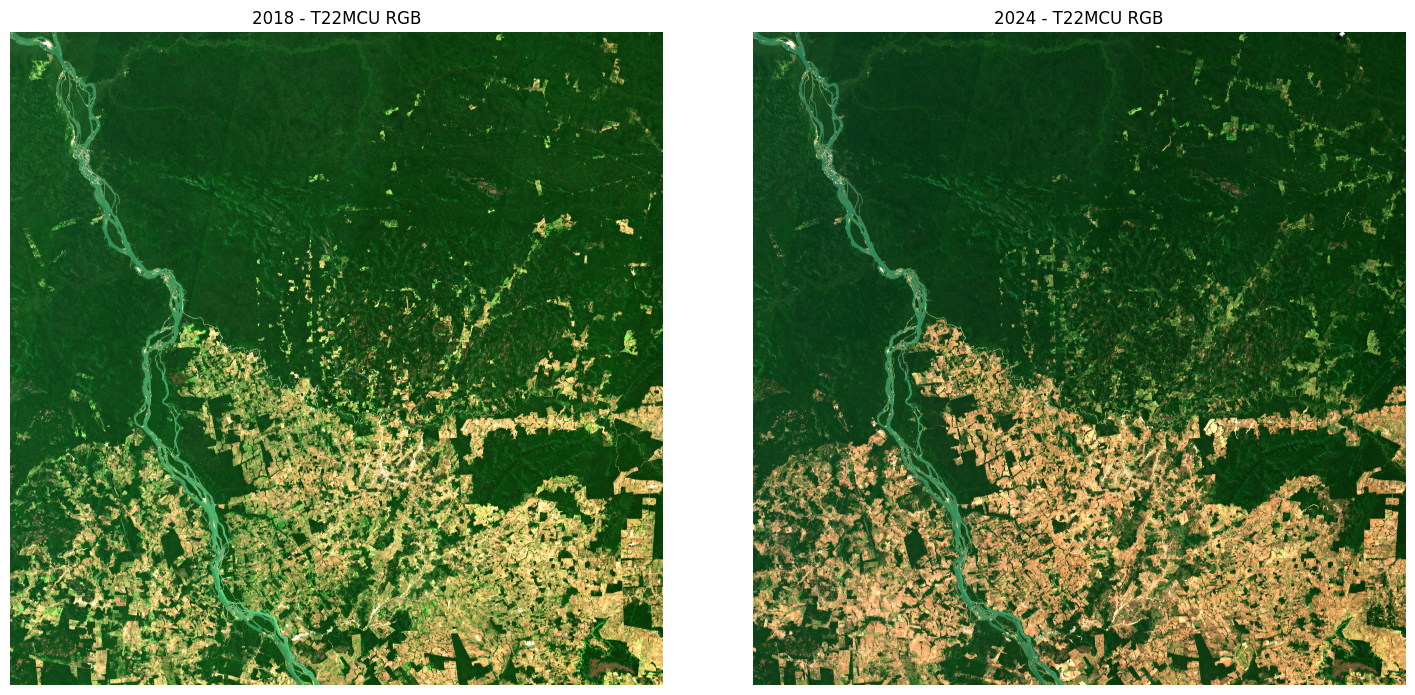

In [8]:
import rasterio
import matplotlib.pyplot as plt

def load_band(year, band):
    path = data_path / year / f"{band}.jp2"
    with rasterio.open(path) as src:
        return src.read(1)

def norm_img(img, low=0.02, high=0.98):
    # Remove zeros and normalize
    img_flat = img[img > 0]  
    q_low, q_high = np.quantile(img_flat, [low, high])
    img_norm = np.clip((img - q_low) / (q_high - q_low), 0, 1)
    return img_norm

# Load RGB bands
rgb_2018 = np.stack([
    load_band("2018", "B04_10m"),  # Red
    load_band("2018", "B03_10m"),  # Green  
    load_band("2018", "B02_10m")   # Blue
], axis=-1)

rgb_2024 = np.stack([
    load_band("2024", "B04_10m"),  # Red
    load_band("2024", "B03_10m"),  # Green
    load_band("2024", "B02_10m")   # Blue
], axis=-1)

# Normalize
rgb_2018_norm = norm_img(rgb_2018)
rgb_2024_norm = norm_img(rgb_2024)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.imshow(rgb_2018_norm)
ax1.set_title("2018 - T22MCU RGB")
ax1.axis('off')

ax2.imshow(rgb_2024_norm)
ax2.set_title("2024 - T22MCU RGB") 
ax2.axis('off')

plt.tight_layout()
plt.show()

In [9]:
import rasterio
import matplotlib.pyplot as plt

def load_band(year, band):
    """Load a band from downloaded data"""
    path = data_path / year / f"{band}.jp2"
    with rasterio.open(path) as src:
        return src.read(1)

def quantile_normalize(img, lower=0.02, upper=0.98):
    """Quantile normalization for visualization"""
    img_flat = img[img > 0]  # Remove zeros
    q_low, q_high = np.quantile(img_flat, [lower, upper])
    img_norm = np.clip((img - q_low) / (q_high - q_low), 0, 1)
    return img_norm

# Load RGB bands for both years
rgb_2018 = np.stack([
    load_band("2018", "B04_10m"),  # Red
    load_band("2018", "B03_10m"),  # Green
    load_band("2018", "B02_10m")   # Blue
], axis=-1)

rgb_2024 = np.stack([
    load_band("2024", "B04_10m"),  # Red
    load_band("2024", "B03_10m"),  # Green
    load_band("2024", "B02_10m")   # Blue
], axis=-1)

# Apply quantile normalization
rgb_2018_norm = quantile_normalize(rgb_2018)
rgb_2024_norm = quantile_normalize(rgb_2024)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.imshow(rgb_2018_norm)
ax1.set_title("2018 - T22MCU RGB Composite")
ax1.axis('off')

ax2.imshow(rgb_2024_norm)
ax2.set_title("2024 - T22MCU RGB Composite")
ax2.axis('off')

plt.tight_layout()
plt.show()

## Answers and Comparison
Looking at these 2018 vs 2024 satellite images, the main difference is way more deforestation. The brown/tan cleared areas expanded significantly, as they went from scattered small patches in 2018 to much larger, more connected cleared zones by 2024. The forest fragmentation is obvious.  Minimal cloud cover. Roads and access routes are more visible in the 2024 image as bright linear features cutting through the landscape. The cleared areas often appear in geometric patterns characteristic of planned agricultural development.

The 2024 image also looks clearer with better contrast, making the boundaries more defined. You can see geometric clearing patterns that suggest systematic agricultural development.